In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'font/NanumGothic.otf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

import eli5
from eli5.sklearn import PermutationImportance



def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
subway = pd.read_csv('data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('data/bus_feature.csv', encoding='utf-8')

In [3]:
test['구'] = test['시군구'].apply(lambda x: x.split()[1])
test['동'] = test['시군구'].apply(lambda x: x.split()[2])

In [4]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [5]:
train['계약년'] = train['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
train['계약월'] = train['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

test['계약년'] = test['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
test['계약월'] = test['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

In [6]:
# 컬럼명에서 '(㎡)', 'k-', '(아파트,주상복합등등)', '(분양형태)' 삭제
def clean_column_name(name):
    name = re.sub(r'k-', '', name)
    name = re.sub(r'\(.*?\)', '', name)
    return name.strip()

# train과 test 데이터프레임의 컬럼명 정리
train.columns = [clean_column_name(col) for col in train.columns]
test.columns = [clean_column_name(col) for col in test.columns]

display(train.head(2))
display(test.head(2))

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,단지분류,전화번호,팩스번호,단지소개기존clob,세대타입,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사,시행사,사용검사일-사용승인일,연면적,주거전용면적,관리비부과면적,전용면적별세대현황,전용면적별세대현황,85㎡~135㎡이하,135㎡초과,홈페이지,등록일자,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,구,동,세대별주차대수,계약년,계약월
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000,강남구,개포동,0.97037,2017,12
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500,강남구,개포동,0.97037,2017,12


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,단지분류,전화번호,팩스번호,단지소개기존clob,세대타입,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사,시행사,사용검사일-사용승인일,연면적,주거전용면적,관리비부과면적,전용면적별세대현황,전용면적별세대현황,85㎡~135㎡이하,135㎡초과,홈페이지,등록일자,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,구,동,세대별주차대수,계약년,계약월
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,언주로 3,NaN,,직거래,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,강남구,개포동,0.970370,2023,7
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,개포로 311,NaN,,중개거래,서울 강남구,아파트,025763999,025763998,NaN,분양,위탁관리,계단식,지역난방,2.0,232.0,포스코,개포우성9차모델링조합,2021-12-01 00:00:00.0,44951.0,24878.0,31174.0,0.0,0.0,232.0,NaN,thesharp-trieh.hthomeservice.com/#/feeManage?_...,2022-01-05 18:02:23.0,2023-09-23 17:23:08.0,NaN,위탁,종합계약,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0,강남구,개포동,1.314655,2023,8


In [10]:
selected_feature_list = ['아파트명', '전용면적', '계약년월', '층', '건축년도', '구', '동']
test = test[selected_feature_list]

selected_feature_list.append('target')
train = train[selected_feature_list]

In [12]:
train['아파트명'].fillna(train['동'] + ' 아파트', inplace=True)

In [13]:
train.isnull().sum()

아파트명      0
전용면적      0
계약년월      0
층         0
건축년도      0
구         0
동         0
target    0
dtype: int64

In [14]:
eda_kkh(train)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
계약년월,int64,1118635,198,0.017700,0,0.000000,201476.153583,418.721931,200701.000000,201110.000000,201507.000000,201804.000000,202306.000000
층,int64,1118635,73,0.006526,0,0.000000,8.872563,5.982760,-4.000000,4.000000,8.000000,12.000000,69.000000
건축년도,int64,1118635,60,0.005364,0,0.000000,1998.759085,9.329888,1961.000000,1992.000000,2000.000000,2005.000000,2023.000000
target,int64,1118635,14518,1.297832,0,0.000000,57995.821855,46428.266559,350.000000,30500.000000,44800.000000,69800.000000,1450000.000000
전용면적,float64,1118635,14611,1.306145,0,0.000000,77.177547,29.365420,10.020000,59.650000,81.880000,84.960000,424.320000
아파트명,object,1118635,6559,0.586340,0,0.000000,nan,nan,nan,nan,nan,nan,nan
구,object,1118635,25,0.002235,0,0.000000,nan,nan,nan,nan,nan,nan,nan
동,object,1118635,337,0.030126,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [15]:
SEED = 1053682552
TARGET = 'target'
NUMERIC_COLS = [f for f in train._get_numeric_data() if f != TARGET]
CAT_COLS = list(test.drop(NUMERIC_COLS,axis=1))

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')


Target         --> target
Numeric Cols   --> ['전용면적', '계약년월', '층', '건축년도']
Categoric Cols --> ['아파트명', '구', '동']


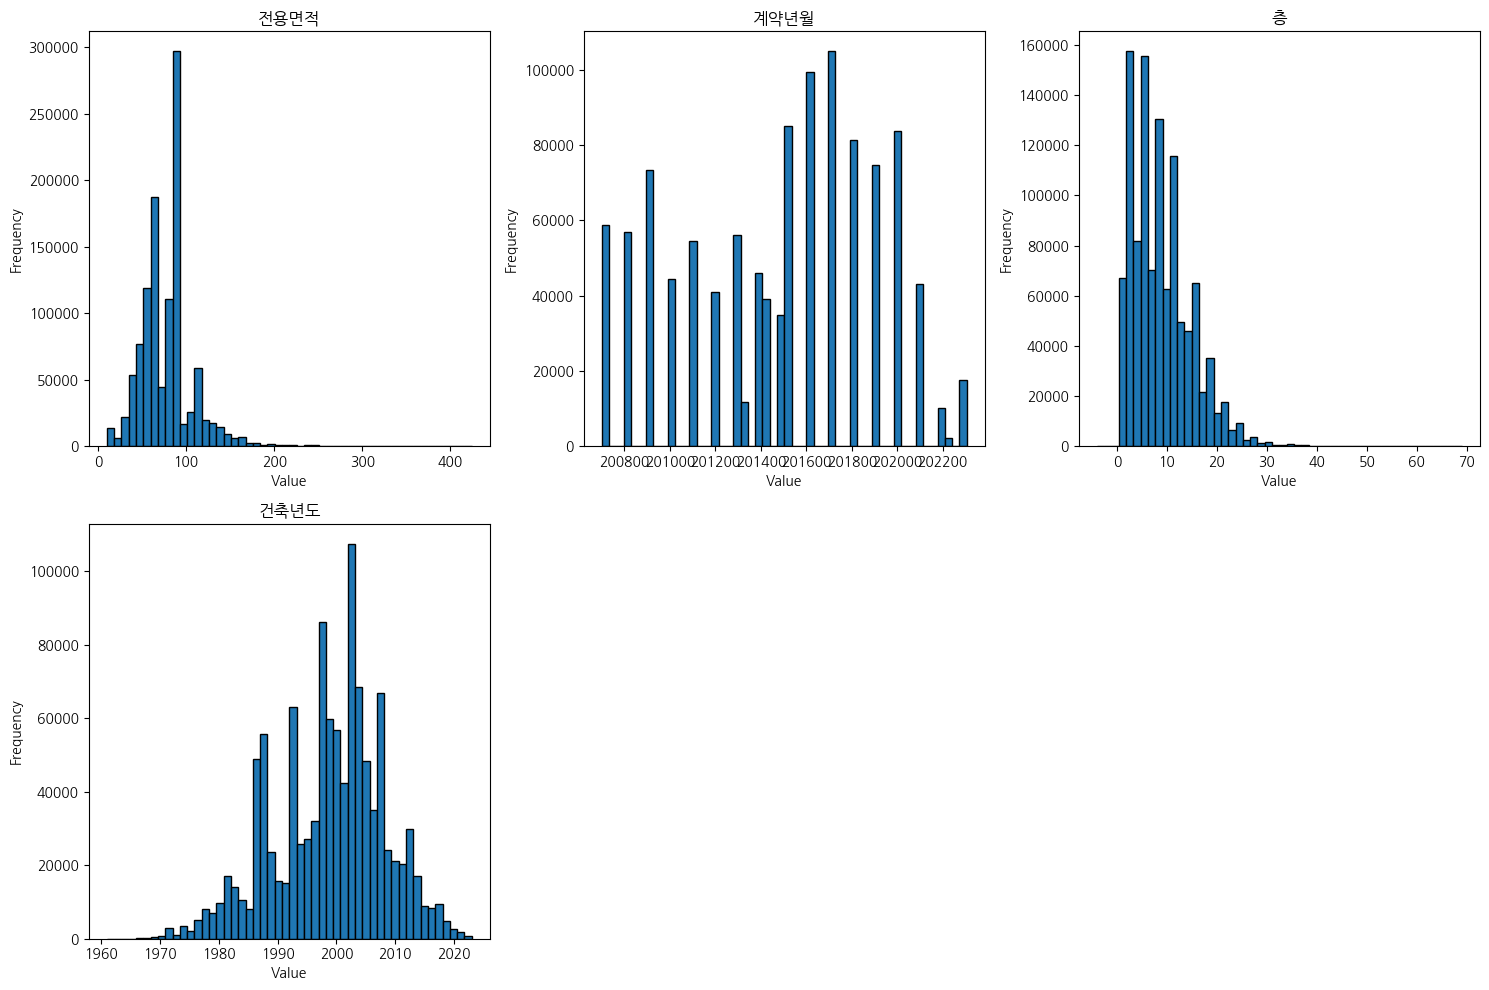

In [16]:
import matplotlib.pyplot as plt

# 데이터 준비: 수치형 데이터만 추출합니다.
numeric_data = train[NUMERIC_COLS]

# 서브플롯 개수
num_features = len(NUMERIC_COLS)
num_cols = 3  # 서브플롯 열 개수
num_rows = (num_features + num_cols - 1) // num_cols  # 필요한 행 개수 계산

plt.figure(figsize=(15, 5 * num_rows))

# 각 수치형 피처에 대해 서브플롯 생성
for i, col in enumerate(NUMERIC_COLS):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(numeric_data[col].dropna(), bins=50, edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# 레이아웃 조정
plt.tight_layout()

# 차트 표시
plt.show()


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, CatBoost
from optuna import create_study
from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler
import optuna

# 데이터 준비
NUMERIC_COLS = ['전용면적', '계약년월', '층', '건축년도']
CAT_COLS = ['아파트명', '구', '동']
X = train.drop(columns=['target'])
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS)
    ])

# 옵티마이저를 위한 하이퍼파라미터 공간 설정
def objective_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 300, 800),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        alpha=trial.suggest_loguniform('alpha', 1e-4, 1e2),
        random_state=SEED
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def objective_lgb(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 300, 800),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        num_leaves=trial.suggest_int('num_leaves', 31, 255),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        random_state=SEED
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def objective_cat(trial):
    model = CatBoostRegressor(
        iterations=trial.suggest_int('iterations', 300, 800),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        depth=trial.suggest_int('depth', 3, 6),
        random_state=SEED,
        verbose=0
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# 옵티마이저 설정 및 최적화
def optimize_model(objective_function, n_trials):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
    study.optimize(objective_function, n_trials=n_trials)
    return study.best_params


# 각 모델의 하이퍼파라미터 최적화
n_trials = 5

print("Optimizing XGBoost...")
xgb_best_params = optimize_model(objective_xgb, n_trials)
print("XGBoost best params:", xgb_best_params)

# print("Optimizing LightGBM...")
# lgb_best_params = optimize_model(objective_lgb, n_trials)
# print("LightGBM best params:", lgb_best_params)

print("Optimizing CatBoost...")
cat_best_params = optimize_model(objective_cat, n_trials)
print("CatBoost best params:", cat_best_params)

# 모델 정의, 학습, 예측, 평가
results = {}
for model_name, model_class, best_params in [
    ('XGBoost', XGBRegressor, xgb_best_params),
    # ('LightGBM', LGBMRegressor, lgb_best_params),
    ('CatBoost', CatBoostRegressor, cat_best_params)
]:
    model = model_class(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'R2 Score': r2, 'RMSE': rmse}

# 결과 출력
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"  R2 Score: {metrics['R2 Score']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")


[I 2024-07-15 23:18:34,997] A new study created in memory with name: no-name-5b89efdf-0e9b-4a1d-9763-524f158a8a33


Optimizing XGBoost...


[I 2024-07-15 23:18:55,613] Trial 0 finished with value: 1670179690.3726208 and parameters: {'n_estimators': 677, 'learning_rate': 0.0003798782534911095, 'max_depth': 4, 'alpha': 0.31588310039776357}. Best is trial 0 with value: 1670179690.3726208.
[I 2024-07-15 23:19:23,563] Trial 1 finished with value: 187229916.92757288 and parameters: {'n_estimators': 793, 'learning_rate': 0.01306671165805956, 'max_depth': 6, 'alpha': 0.5057309506977974}. Best is trial 1 with value: 187229916.92757288.
[I 2024-07-15 23:19:41,705] Trial 2 finished with value: 1203341647.2454197 and parameters: {'n_estimators': 748, 'learning_rate': 0.0011874581171232713, 'max_depth': 3, 'alpha': 1.9997495547370978}. Best is trial 1 with value: 187229916.92757288.
[I 2024-07-15 23:19:52,991] Trial 3 finished with value: 161270846.3549493 and parameters: {'n_estimators': 379, 'learning_rate': 0.07672948312461544, 'max_depth': 5, 'alpha': 0.0005019860496167036}. Best is trial 3 with value: 161270846.3549493.
[I 2024-07

XGBoost best params: {'n_estimators': 379, 'learning_rate': 0.07672948312461544, 'max_depth': 5, 'alpha': 0.0005019860496167036}
Optimizing CatBoost...


[I 2024-07-15 23:20:47,721] Trial 0 finished with value: 1709598728.5920904 and parameters: {'iterations': 677, 'learning_rate': 0.0003798782534911095, 'depth': 4}. Best is trial 0 with value: 1709598728.5920904.
[I 2024-07-15 23:21:26,436] Trial 1 finished with value: 155591559.9854819 and parameters: {'iterations': 592, 'learning_rate': 0.09048308290706156, 'depth': 5}. Best is trial 1 with value: 155591559.9854819.
[I 2024-07-15 23:22:18,926] Trial 2 finished with value: 355828629.8021107 and parameters: {'iterations': 695, 'learning_rate': 0.007111476293272711, 'depth': 6}. Best is trial 1 with value: 155591559.9854819.
[I 2024-07-15 23:22:50,145] Trial 3 finished with value: 2043011293.3804007 and parameters: {'iterations': 479, 'learning_rate': 0.0001029942855626323, 'depth': 5}. Best is trial 1 with value: 155591559.9854819.
[I 2024-07-15 23:23:16,648] Trial 4 finished with value: 199761484.49929672 and parameters: {'iterations': 379, 'learning_rate': 0.07672948312461544, 'depth

CatBoost best params: {'iterations': 592, 'learning_rate': 0.09048308290706156, 'depth': 5}
0:	learn: 44113.3529511	total: 62.4ms	remaining: 36.9s
1:	learn: 42078.5965066	total: 125ms	remaining: 36.8s
2:	learn: 40334.5029322	total: 182ms	remaining: 35.7s
3:	learn: 38737.9588722	total: 241ms	remaining: 35.4s
4:	learn: 37285.3598154	total: 308ms	remaining: 36.2s
5:	learn: 36010.8760488	total: 369ms	remaining: 36s
6:	learn: 34864.1659605	total: 434ms	remaining: 36.2s
7:	learn: 33813.4081582	total: 492ms	remaining: 35.9s
8:	learn: 32843.3331719	total: 555ms	remaining: 36s
9:	learn: 31978.3994210	total: 612ms	remaining: 35.6s
10:	learn: 31183.1876691	total: 672ms	remaining: 35.5s
11:	learn: 30463.7654961	total: 727ms	remaining: 35.2s
12:	learn: 29671.7102888	total: 785ms	remaining: 35s
13:	learn: 29040.5912212	total: 842ms	remaining: 34.7s
14:	learn: 28418.0156594	total: 896ms	remaining: 34.5s
15:	learn: 27844.3493626	total: 955ms	remaining: 34.4s
16:	learn: 27327.1780421	total: 1.01s	remai

In [30]:
from catboost import CatBoostRegressor, CatBoost

# 로그 출력을 억제하기 위한 설정
import logging
logging.getLogger('xgboost').setLevel(logging.ERROR)
CatBoost._log_level = 'Silent'  # CatBoost의 로그 억제 설정

# 최종 모델 정의 및 학습
def train_and_predict(model_class, best_params):
    model = model_class(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X, y)
    predictions = pipeline.predict(test)
    return predictions.astype(int)  # 예측값을 int로 변환

# 예측 및 저장
print("Predicting using XGBoost...")
xgb_predictions = train_and_predict(XGBRegressor, xgb_best_params)
submission_xgb = pd.DataFrame({
    'target': xgb_predictions
})
submission_xgb.to_csv('test_xgb_12699.csv', index=False)

# print("Predicting using LightGBM...")
# lgb_predictions = train_and_predict(LGBMRegressor, lgb_best_params)
# submission_lgb = pd.DataFrame({
#     'target': lgb_predictions
# })
# submission_lgb.to_csv('test_lgb.csv', index=False)

print("Predicting using CatBoost...")
cat_predictions = train_and_predict(CatBoostRegressor, cat_best_params)
submission_cat = pd.DataFrame({
    'target': cat_predictions
})
submission_cat.to_csv('test_cat_12527.csv', index=False)

Predicting using XGBoost...


KeyError: 'target'